<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S11/blob/master/S11trail1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [54]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-_y1aucd6
All libraries are successfully installed!


In [55]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA4')

In [0]:
import numpy as np
from eva4albumentations import AlbumentationTransforms
import albumentations as A


channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                       A.Rotate((-10.0, 10.0)),
                                       A.PadIfNeeded(40,40),
                                       A.RandomCrop(32,32),
                                       A.HorizontalFlip(),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=8, max_w_size=8) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



In [58]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [60]:

import numpy as np
dataiter = iter(train_loader)
images, labels = dataiter.next()
i = images[90].numpy()
print(np.max(i), np.min(i))

2.085823 -1.8352839


torch.Size([512, 3, 32, 32])
torch.Size([512])


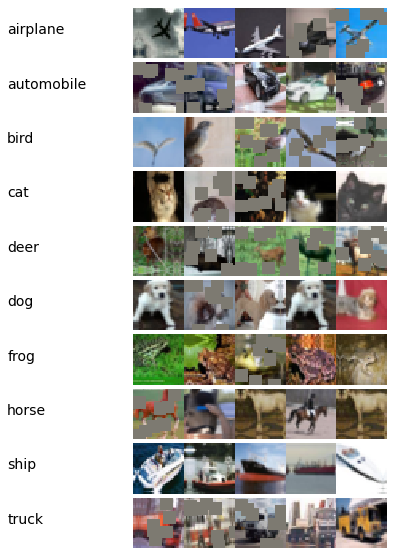

In [61]:

from __future__ import print_function

def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [62]:
import a11
import torch

model = a11.Quiz11()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

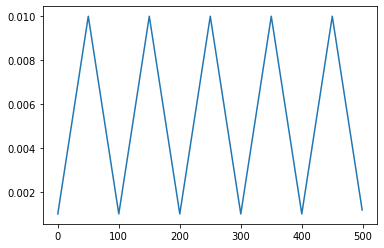

In [63]:
def get_triangular_lr(iteration, stepsize, base_lr, max_lr):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lr


num_iterations = 500
stepsize = 50
base_lr = 0.001
max_lr = 0.01
lr_trend = list()

for iteration in range(num_iterations):
    lr = get_triangular_lr(iteration, stepsize, base_lr, max_lr)
    # Update your optimizer to use this learning rate in this iteration
    lr_trend.append(lr)

plt.plot(lr_trend)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


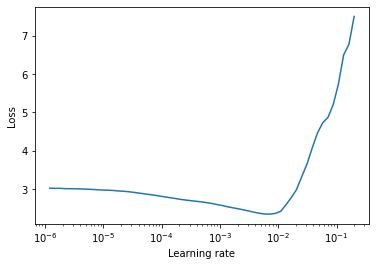

In [64]:
# LR finder fast ai approach
from lrfinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

In [66]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 25
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                 max_lr=0.01,
                 total_steps=25,
                 epochs=25,
                 pct_start=0.2,
                 anneal_strategy='cos',
                 cycle_momentum=False,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=10.,
                 final_div_factor=1e4,
                 last_epoch=-1)



model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.288097).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0033, Accuracy: 40.10%; Test set: Average loss: 1.2881, Accuracy: 53.43%
Learning Rate = 0.001000



Validation loss decreased (1.288097 --> 1.097805).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0026, Accuracy: 51.85%; Test set: Average loss: 1.0978, Accuracy: 62.01%
Learning Rate = 0.002318



Validation loss decreased (1.097805 --> 0.957560).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0026, Accuracy: 54.82%; Test set: Average loss: 0.9576, Accuracy: 66.94%
Learning Rate = 0.005500



Validation loss decreased (0.957560 --> 0.911325).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0024, Accuracy: 59.84%; Test set: Average loss: 0.9113, Accuracy: 69.77%
Learning Rate = 0.008682



Validation loss decreased (0.911325 --> 0.745046).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0019, Accuracy: 65.97%; Test set: Average loss: 0.7450, Accuracy: 74.17%
Learning Rate = 0.010000



Validation loss decreased (0.745046 --> 0.721814).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0016, Accuracy: 70.84%; Test set: Average loss: 0.7218, Accuracy: 76.08%
Learning Rate = 0.009938



Validation loss decreased (0.721814 --> 0.623346).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0015, Accuracy: 73.96%; Test set: Average loss: 0.6233, Accuracy: 78.85%
Learning Rate = 0.009755



Validation loss decreased (0.623346 --> 0.551534).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0014, Accuracy: 75.29%; Test set: Average loss: 0.5515, Accuracy: 81.63%
Learning Rate = 0.009455



Validation loss decreased (0.551534 --> 0.523391).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0013, Accuracy: 77.52%; Test set: Average loss: 0.5234, Accuracy: 82.22%
Learning Rate = 0.009045



Validation loss decreased (0.523391 --> 0.483022).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0012, Accuracy: 79.15%; Test set: Average loss: 0.4830, Accuracy: 83.73%
Learning Rate = 0.008536



Validation loss decreased (0.483022 --> 0.446913).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0011, Accuracy: 80.30%; Test set: Average loss: 0.4469, Accuracy: 85.25%
Learning Rate = 0.007939



Validation loss decreased (0.446913 --> 0.444288).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0010, Accuracy: 81.34%; Test set: Average loss: 0.4443, Accuracy: 85.18%
Learning Rate = 0.007270



Validation loss decreased (0.444288 --> 0.410611).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0010, Accuracy: 82.56%; Test set: Average loss: 0.4106, Accuracy: 86.31%
Learning Rate = 0.006545



Epoch: 14, Train set: Average loss: 0.0009, Accuracy: 83.67%; Test set: Average loss: 0.4167, Accuracy: 86.05%
Learning Rate = 0.005782



Validation loss decreased (0.410611 --> 0.394374).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0009, Accuracy: 84.37%; Test set: Average loss: 0.3944, Accuracy: 87.04%
Learning Rate = 0.005000



Validation loss decreased (0.394374 --> 0.377592).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0008, Accuracy: 85.04%; Test set: Average loss: 0.3776, Accuracy: 87.49%
Learning Rate = 0.004218



Validation loss decreased (0.377592 --> 0.370263).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0008, Accuracy: 85.76%; Test set: Average loss: 0.3703, Accuracy: 87.69%
Learning Rate = 0.003455



Validation loss decreased (0.370263 --> 0.354114).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0008, Accuracy: 86.45%; Test set: Average loss: 0.3541, Accuracy: 88.24%
Learning Rate = 0.002730



Validation loss decreased (0.354114 --> 0.348965).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0007, Accuracy: 87.19%; Test set: Average loss: 0.3490, Accuracy: 88.51%
Learning Rate = 0.002061



Epoch: 20, Train set: Average loss: 0.0007, Accuracy: 87.85%; Test set: Average loss: 0.3492, Accuracy: 88.49%
Learning Rate = 0.001465



Validation loss decreased (0.348965 --> 0.338670).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0007, Accuracy: 88.09%; Test set: Average loss: 0.3387, Accuracy: 88.83%
Learning Rate = 0.000955



Epoch: 22, Train set: Average loss: 0.0007, Accuracy: 88.25%; Test set: Average loss: 0.3387, Accuracy: 88.94%
Learning Rate = 0.000545



Validation loss decreased (0.338670 --> 0.335760).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0006, Accuracy: 88.73%; Test set: Average loss: 0.3358, Accuracy: 88.87%
Learning Rate = 0.000245



Validation loss decreased (0.335760 --> 0.333516).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0006, Accuracy: 88.44%; Test set: Average loss: 0.3335, Accuracy: 89.02%
Learning Rate = 0.000062



Validation loss decreased (0.333516 --> 0.333191).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0006, Accuracy: 88.88%; Test set: Average loss: 0.3332, Accuracy: 89.04%
Learning Rate = 0.000000



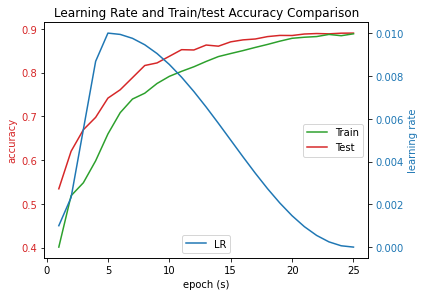

In [67]:
fig, ax1 = plt.subplots()
t = np.arange(1, 26)
color = 'tab:red'
ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('accuracy', color=color)
testline, = ax1.plot(t, model.stats().test_acc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
trainline, = ax1.plot(t, model.stats().train_acc, color=color)
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)  # we already handled the x-label with ax1
lrline, = ax2.plot(t, model.stats().lr, color=color)
ax2.legend((lrline, ), ('LR',), loc=8)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Accuracy Comparison")
plt.show()

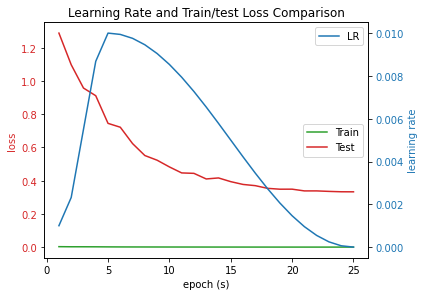

In [68]:
fig, ax1 = plt.subplots()
t = np.arange(1, 26)
color = 'tab:red'
ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('loss', color=color)
testline, = ax1.plot(t, model.stats().avg_test_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
trainline, = ax1.plot(t, model.stats().avg_train_loss, color=color)
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)  # we already handled the x-label with ax1
lrline, = ax2.plot(t, model.stats().lr, color=color)
ax2.legend((lrline, ), ('LR',), loc=1)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Loss Comparison")
plt.show()

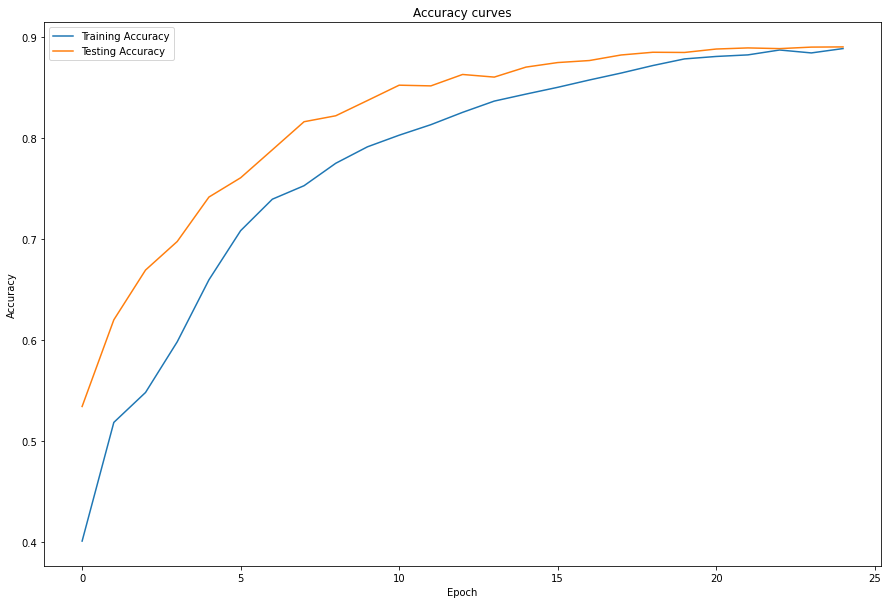

In [69]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Epoch", ylabel="Accuracy")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()